In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Pendulum-v2')

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        mb_noise=False,
        coef_u = 1.,
        coef_tau = .1,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
#learning   
l = .1
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
#a.load_weights('../saved_agent/linear_init.h5')
a.actor.load_weights('../saved_agent/sample_02.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, episode_time=10.)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
  980/10000 [=>............................] - ETA: 7s - reward: -0.5292WARNING:tensorflow:From /Users/takeuchi_ibuki/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
10000/10000 [==============================] - 62s 6ms/step - reward: -0.2894
78 episodes - episode_reward: -36.766 [-78.190, -9.157] - loss: 0.242 - mean_squared_error: 0.483 - mean_q: 0.174

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: -0.1506
45 episodes - episode_reward: -33.691 [-47.574, -20.043] - loss: 0.017 - mean_squared_error: 0.033 - mean_q: 0.269

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -0.1549
46 episodes - episode_reward: -33.926 [-52.811, -20.946] 

10000/10000 [==============================] - 82s 8ms/step - reward: -0.0618
44 episodes - episode_reward: -13.736 [-28.344, -7.070] - loss: 0.002 - mean_squared_error: 0.003 - mean_q: 0.399

Interval 36 (350000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -0.0572
45 episodes - episode_reward: -12.980 [-19.031, -6.062] - loss: 0.002 - mean_squared_error: 0.003 - mean_q: 0.351

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -0.0529
44 episodes - episode_reward: -12.002 [-23.403, -1.870] - loss: 0.001 - mean_squared_error: 0.003 - mean_q: 0.305

Interval 38 (370000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -0.0492
44 episodes - episode_reward: -11.041 [-23.045, -3.544] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: 0.247

Interval 39 (380000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -0.0370
46

10000/10000 [==============================] - 83s 8ms/step - reward: -0.0507
45 episodes - episode_reward: -11.200 [-20.224, -6.251] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: -0.097

Interval 72 (710000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -0.0500
46 episodes - episode_reward: -10.926 [-15.678, -6.024] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: -0.097

Interval 73 (720000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -0.0493
45 episodes - episode_reward: -10.889 [-18.366, -5.436] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: -0.102

Interval 74 (730000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -0.0470
45 episodes - episode_reward: -10.479 [-19.041, -4.989] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: -0.103

Interval 75 (740000 steps performed)
10000/10000 [==============================] - 83s 8ms/step - reward: -0.052

(197, 2)
(226, 2)
(205, 2)
(216, 2)
(213, 2)
(238, 2)
(204, 2)
(227, 2)
(245, 2)
(211, 2)


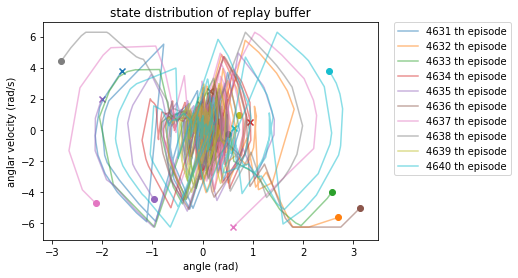

In [6]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(a.state_memory):
    if i<len(a.state_memory)-10:
        continue
    print(em.shape)
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i % 10])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i % 10])
    plt.plot(em[:,0], em[:,1], color=cycle[i % 10], label=f'{i+1} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of replay buffer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.xlim(-10, 10)
plt.show()

In [7]:
a.training = False
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = a.forward(x)
    tau = np.clip(tau, .01, 1.)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(a.forward(env.state)[0])
states = np.array(states)
detail_states = np.array(detail_states)

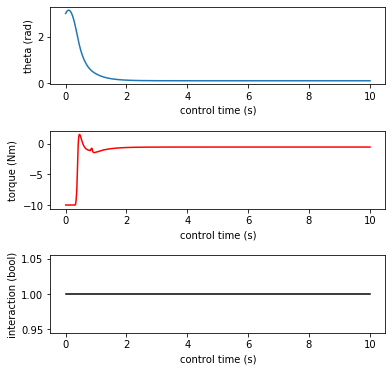

In [8]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('theta (rad)')
plt.plot(detail_time_log, detail_states[:,0])
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('torque (Nm)')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [23]:
a.save_weights('../saved_agent/learned_self_large_noise1.h5')

In [29]:
int(np.ceil(tau) * 100)

100